#  An analysis of the acoustic signature of looms <a id='top'></a>

## Introduction

In this notebook, we will focus on the acoustic signature of 3 distinctive looms of the [Musée de la Soierie](https://www.ville-charlieu.fr/decouvrir-charlieu/musee-de-la-soierie) de Charlieu, France

- French *hand loom* produced by an unknown company in the 19th century
- French *power loom* produced by the company **Nanterme & Fils** in 1925
- Japanese *air-jet loom* produced by the company **Tsudakoma** in 1980

On the one hand, we will start by analyzing the time domain signature of the fly-shuttle in order to determine the picks per minute (ppm) produced by the loom. On the other hand, we will focus on the evolution of noise exposure related to the weaving process by measuring the noise and the frequency components of the respective looms.

## Materials and methods

This study is based on the Python Notebooks created and maintained by **Meinard Müller** **[[1]](#ref)** which provide detailed textbook-like explanations of central techniques and algorithms 
with a particular focus on the audio domain in combination with Python code examples that illustrate how to implement the theory.

>*The fly-shuttle loom is one of the most challenging noise control problem of the textile industry. The invention of the power loom in the late 1700's brought high noise level into the weave room and today it is not unusual to observe noise level in excess of 100 dB(A) in typical weaving operations. The repetitive impact nature of the noise from a single machine is compounded by the superpositioning of sounds from hundreds of other looms to produce continuous noise levels well above recommended exposure limits.* 

**Picking Mechanism**

![Picking Mechanism](https://cdn.britannica.com/84/1684-004-38042573/motions-weaving.jpg)


Dominant noise sources of the weaving looms are often related to their picking mechanisms  which propels the fly-shuttle back and forth **[[2]](#ref)**. These picking mechanisms create sudden variations in amplitude which have an important impact in the time domain. In order to analyze the signature of these variations, we will start by detecting the onset positions of the fly-shuttle which appears to be a good indicator for defining the number of picks per minutes produced by the loom.

**Onset detection measurements**

Recordings were made using two long shotgun microphones (**Rode**, **NTG-8**, Australia) oriented towards the loom's picker at approximately 0.5 m from the noise source. The microphones were connected to a portable recorder (**Zoom**, **F8n**, Japan) with a sampling rate of 48 kHz and a bit depth of 24 bit.


**Noise measurements**

Noise level and frequency characteristics were made using class 1 integrating sound level meter (**Brüel & Kjaer**, **Type 2245**, Denmark) and recordings with a ½-inch Free-field Microphone (**Brüel & Kjaer**, **Type 4966**, Denmark) with a sampling rate of 44.1 kHz and a bit depth of 16 bit. The instrument was calibrated on a daily basis using a calibrator supplied by the manufacturer of SLM before the noise level measurements (**Brüel & Kjaer**, **Type 4231**, Denmark). These measurements were made by selecting 1/3 octave band and LAF-weighting network each second. Noise parameters were measured at a distance of 1.5 m from the noise sources of the looms, placing the sound level meter and microphone at a height of approximately 1.7 m, closer to the identified worker's hearing position during work.

## Results and discussion

- [Local energy function ](#local)
- [Energy-based novelty function](#energy)
 - [Logarithmic compression](#log)
 
 
- [Spectral-based novelty function](#spectral) 
 - [Discrete Derivative, Half-Wave Rectification, Accumulation](#discrete)
 - [Subtracting local average](#average)


- [Peak picking strategy](#peak)
 - [Smoothed spectral-based novelty function](#smooth)
 - [Picks per minute (ppm)](#picks)
 
 
- [Noise measurements](#noise)
- [Power spectrums](#power)

Let's start by importing all the necessary packages and the audio files used for the analysis.

In [1]:
import os, sys
import sys
import numpy as np
from scipy import signal
from  matplotlib import pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd

In [2]:
hand = "audio/hand-loom.wav"
power = "audio/power-loom.wav"
airjet = "audio/airjet-loom.wav"

### Local energy function <a id='local'></a>

To begin, we will start by dectecting the fly-shuttle onsets which go along with a sudden increase of the signal's energy. Based on this assumption, a straightforward way to detect the onsets is to transform the signal into a **local energy function**.

Local energy is basically the magnitude of an envelope function of the signal. Peaks in the local energy function occur at the same locations as peaks in the phase congruency function. Therefore, we will design a function which indicates the local energy of the signal for each time instance and then look for sudden changes in this function. 

In [3]:
Fs = 48000 # Audio sampling rate

In [4]:
x, Fs = librosa.load(power, sr=Fs)
x_duration = len(x) / Fs

In [5]:
N, H = 2048, 1024 # Window length & hop-size parameter
w = signal.hann(N) # Hanning window 

# Calculate local energy
x_square = x**2
energy_local = np.convolve(x_square, w**2, 'same')

time = np.arange(x.shape[0]) / Fs

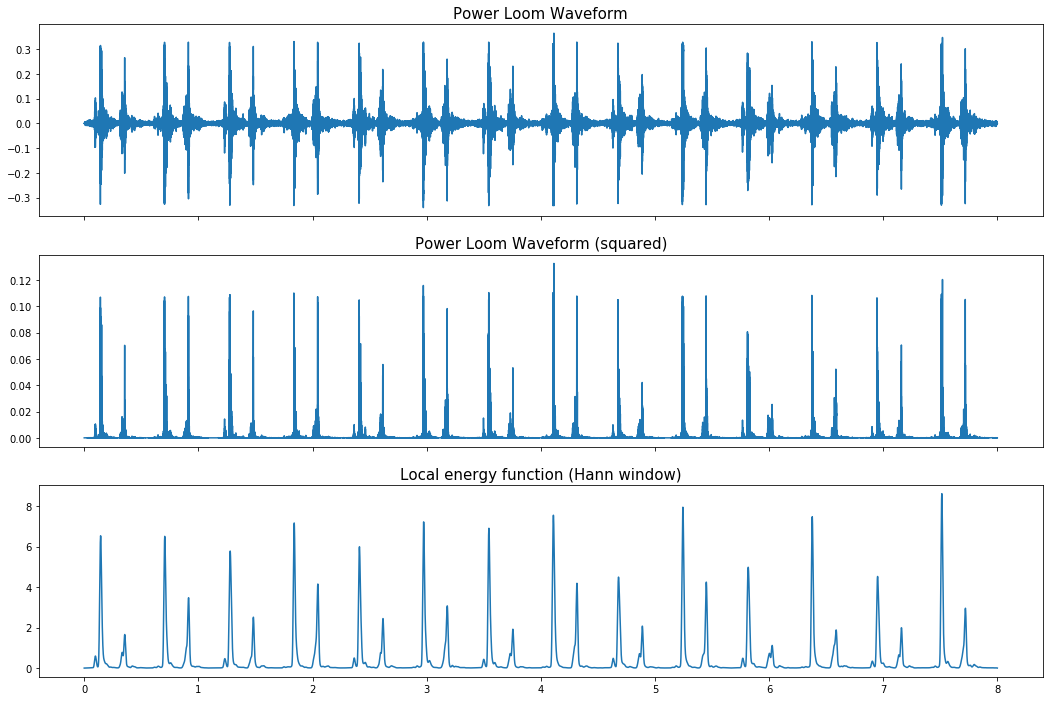

In [6]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(18, 12))

ax[0].plot(time, x)
ax[0].set_title('Power Loom Waveform', size=15)
ax[1].plot(time, x_square)
ax[1].set_title('Power Loom Waveform (squared)', size=15)
ax[2].plot(time, energy_local)
ax[2].set_title('Local energy function (Hann window)', size=15);

### Energy-based novelty function <a id='energy'></a>

#### Logarithmic Compression <a id='log'></a>

Moreover, to account for the fact that human perception of sound intensity is logarithmic in nature, one often applies a logarithm to the energy values, for example, by switching to the logarithmic decibel or by applying **logarithmic compression**.

Besides our window length **N**, we introduce in the following implementation also a hope-size parameter **H**, which allows for decreasing the feature sampling rate of the computed novelty. Furthermore, dividing by its maximum value, we will normalize the novelty function. In the next figure, continuing our running example, we can observe that some of the weak fly-shuttle onsets become visible (see  t=0.3 sec  and  t=1.4 sec ) when using **logarithmic compression**. As a downside of logarithmic compression, some noise-like sound components may be amplified, possibly leading to spurious peaks.

>*N.B. The degree of compression can be adjusted by the constant **gamma** : the larger gamma, the larger the resulting compression. The following code cell illustrates the compression function for a constant gamma default value of 100.*

In [7]:
def energy_based_novelty(x, Fs, N=2048, H=1024, gamma=100, norm=True):
    """Compute energy-based novelty function
     Meinard Müller, FMP, Notebook: C6/C6S1_NoveltyEnergy.ipynb

    Args:
        x (np.ndarray): Signal
        Fs (scalar): Sampling rate 
        N (int): Window size (Default value = 2048)
        H (int): Hope size (Default value = 1024)
        gamma (float): Parameter for logarithmic compression (Default value = 100)
        norm (bool): Apply max norm (if norm==True) (Default value = True)

    Returns:
        novelty_energy (np.ndarray): Energy-based novelty function
        Fs_feature (scalar): Feature rate
    """
    # x_square = x**2
    w = signal.hann(N)
    Fs_feature = Fs / H
    energy_local = np.convolve(x**2, w**2, 'same')
    energy_local = energy_local[::H]
    
    if gamma is not None:
        energy_local = np.log(1 + gamma * energy_local)
    
    energy_local_diff = np.diff(energy_local)
    energy_local_diff = np.concatenate((energy_local_diff, np.array([0])))
    novelty_energy = np.copy(energy_local_diff)
    novelty_energy[energy_local_diff < 0] = 0
    
    if norm:
        max_value = max(novelty_energy)
        if max_value > 0:
            novelty_energy = novelty_energy / max_value
    
    return novelty_energy, Fs_feature

In [8]:
nov_1, Fs_nov = energy_based_novelty(x, Fs=Fs, N=N, H=H, gamma=None)
nov_2, Fs_nov = energy_based_novelty(x, Fs=Fs, N=N, H=H, gamma=100)

time = np.arange(nov_1.shape[0]) / Fs_nov

As shown in this example, **logarithmic compression** also shifted some peak positions forward.

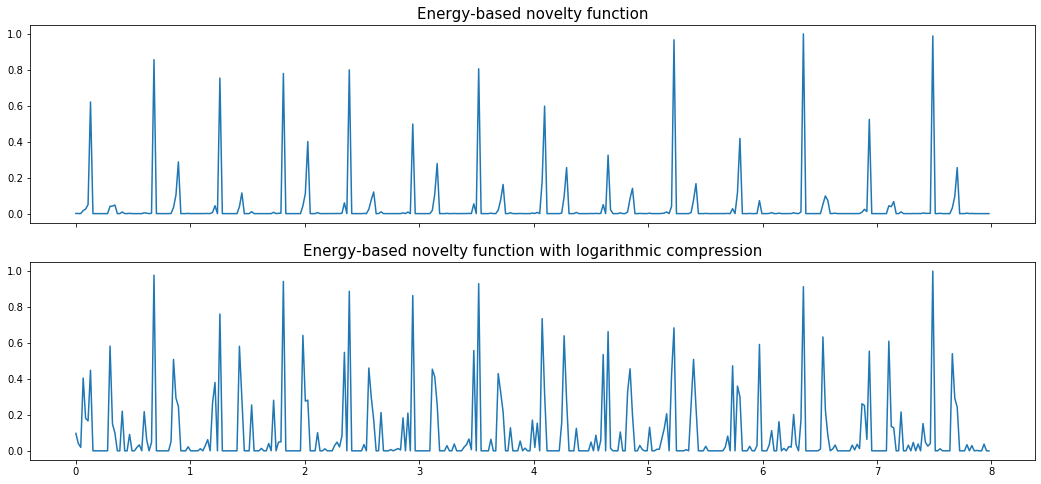

In [9]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(18, 8))

ax[0].plot(time, nov_1)
ax[0].set_title('Energy-based novelty function', size=15)
ax[1].plot(time, nov_2)
ax[1].set_title('Energy-based novelty function with logarithmic compression', size=15);

### Spectral-based novelty function <a id='spectral'></a>

Onset detection may often becomes a hard and ill-defined problem for simultaneously occurring sound events. For example, a sound event of low intensity may be masked by an event of high intensity. However, a noise-like broadband transients may be still observable in certain frequency bands even in polyphonic mixtures. Motivated by such observations, the idea of spectral-based novelty detection was selected to first convert the signal into a time–frequency representation and then to capture changes in the frequency content of the loom.

#### Discrete Derivative, Half-Wave Rectification, Accumulation <a id='discrete'></a>

Let's now determine the sinusoidal frequency and phase content of the local sections of our signal over time by using a **short-time Fourier transform (STFT)** with a *hanning window* for smoothing the values.

In [10]:
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')

In the next step, we compute the **discrete temporal derivative** of the compressed spectrum  **Y** . Similarly to the **energy-based novelty function**, we only consider the positive differences (increase in intensity) and discard negative ones by applying half-wave rectification. Finally we add up the positive differences over the frequency axis (accumulation step), which yields the **spectral-based novelty function**.

In [11]:
gamma = 100
Y = np.log(1 + gamma * np.abs(X))

Y_diff = np.diff(Y, n = 1)
Y_diff[Y_diff < 0] = 0

nov_3 = np.sum(Y_diff, axis=0)
nov_3 = np.concatenate((nov_3, np.array([0])))

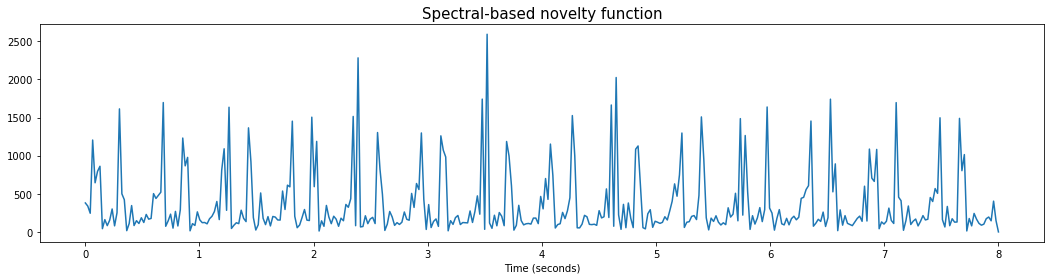

In [12]:
time = np.arange(nov_3.shape[0]) / Fs_nov

plt.figure(figsize=(18, 4))
plt.plot(time, nov_3)
plt.title('Spectral-based novelty function', size=15)
plt.xlabel('Time (seconds)');

#### Subtracting local average <a id='average'></a>

Furthermore, one can enhance the properties of the **spectral novelty function** by applying suitable postprocessing steps. For example, in view of a subsequent peak-picking step, one objective may be to enhance the peak structure of the novelty function, while suppressing small fluctuations.

In [13]:
def compute_local_average(x, M):
    """Compute local average of signal
    Meinard Müller, FMP, Notebook: C6/C6S1_NoveltySpectral.ipynb
    
    Args:
        x (np.ndarray): Signal
        M (int): Determines size (2M+1) in samples of centric window used for local average

    Returns:
        local_average (np.ndarray): Local average signal
    """
    L = len(x)
    local_average = np.zeros(L)
    
    for m in range(L):
        a = max(m - M, 0)
        b = min(m + M + 1, L)
        local_average[m] = (1 / (2 * M + 1)) * np.sum(x[a:b])
    
    return local_average

The **enhanced spectral-based novelty function** is obtained by subtracting the local average from  our initial function (nov_3) and by only keeping the positive part (**half-wave rectification**). Furthermore, we normalize the resulting novelty function by dividing it by its maximum value.

In [14]:
local_average = compute_local_average(nov_3, M=10)
nov_norm = nov_3 - local_average
nov_norm[nov_norm < 0] = 0
nov_norm = nov_norm / max(nov_norm)

time = np.arange(nov_3.shape[0]) / Fs_nov

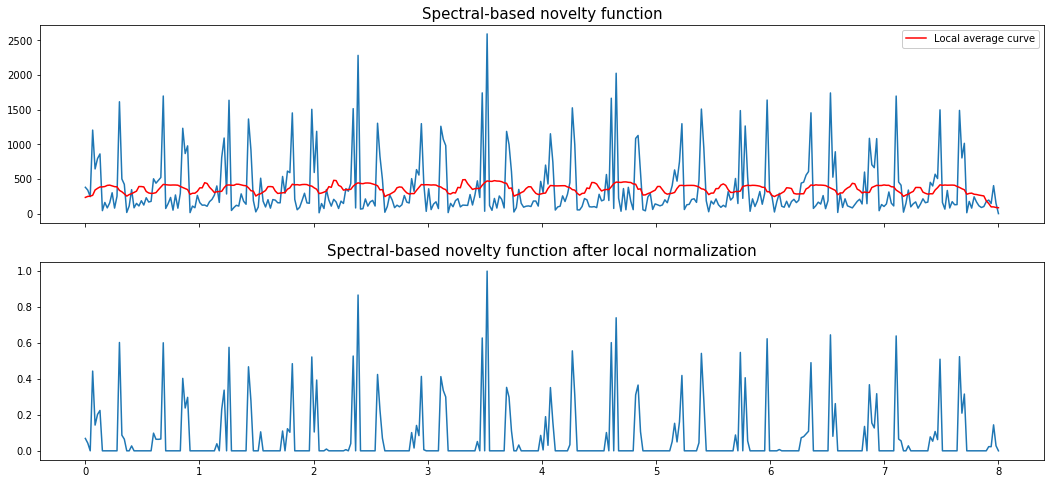

In [15]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(18, 8))

ax[0].plot(time, nov_3)
ax[0].plot(time, local_average, 'r', label='Local average curve')
ax[0].set_title('Spectral-based novelty function', size=15)
ax[0].legend(loc='upper right', framealpha=1)
ax[1].plot(time, nov_norm)
ax[1].set_title('Spectral-based novelty function after local normalization', size=15);

Finally, we can compare the **energy-based novelty curve** with the the **spectral-based novelty curve** using the power loom example.

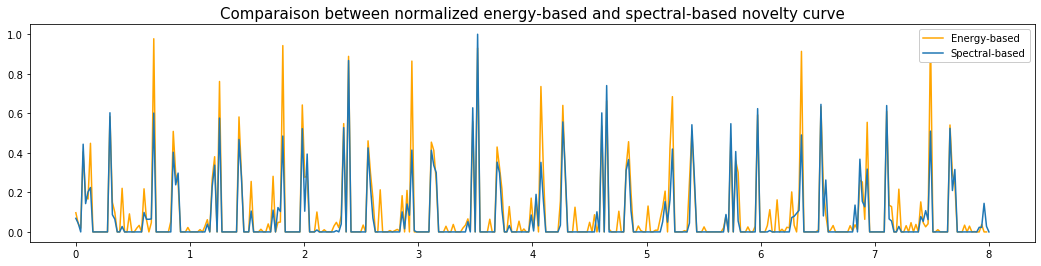

In [16]:
time = np.arange(nov_2.shape[0]) / Fs_nov
time1 = np.arange(nov_norm.shape[0]) / Fs_nov

plt.figure(figsize=(18, 4))
plt.plot(time, nov_2, 'orange', label='Energy-based')
plt.plot(time1, nov_norm, label='Spectral-based')
plt.title('Comparaison between normalized energy-based and spectral-based novelty curve', size=15)
plt.legend(loc='upper right', framealpha=1);

### Peak picking strategy <a id='peak'></a>

The fly-shuttle peaks or local maximum of the novelty function appears to be good indicators for onset positions. Thus, in the case that our novelty function has a clear peak structure with impulse-like and well-separated peaks, the selection of peaks seems a simple problem. 

However, some of the weaving looms have to deal with rather noisy novelty functions that have many spurious peaks. In such situations, the strategy used for **peak picking** typically has a substantial influence on the quality of the final detection or segmentation result.

In [17]:
def peak_picking_simple(x, threshold=None):
    """Peak picking strategy looking for positions with increase followed by descrease
    Meinard Müller, FMP, Notebook: C6/C6S1_PeakPicking.ipynb

    Args:
        x (np.ndarray): Input function
        threshold (float): Lower threshold for peak to survive

    Returns:
        peaks (np.ndarray): Array containing peak positions
    """
    peaks = []
    
    if threshold is None:
        threshold = np.min(x) - 1
    for i in range(1, x.shape[0] - 1):
        if x[i - 1] < x[i] and x[i] > x[i + 1]:
            if x[i] >= threshold:
                peaks.append(i)
    peaks = np.array(peaks)
    
    return peaks

In [18]:
def plot_function_peak_positions(nov, Fs_nov, peaks, title):
    
    peaks_sec = peaks / Fs_nov
    time = np.arange(nov.shape[0]) / Fs_nov
    
    plt.plot(time, nov)
    plt.title(title, size=15)
    plt.vlines(peaks_sec, 0, 1, color='r', linestyle=':', linewidth=2)

In [19]:
threshold=0.35 # peak picking global threshold

peaks = peak_picking_simple(nov_norm, threshold=threshold)

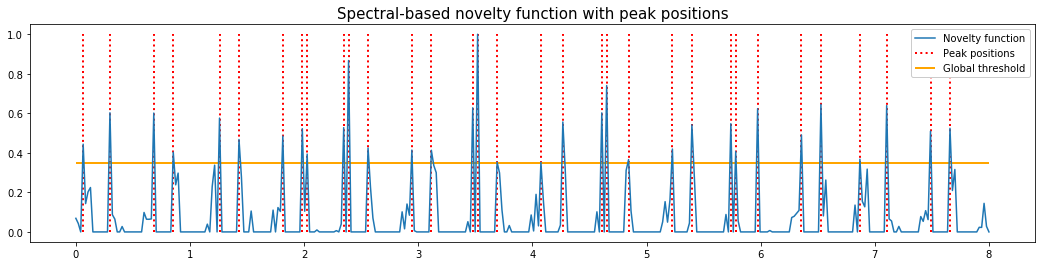

In [20]:
plt.figure(figsize=([18, 4]))
plot_function_peak_positions(nov_norm, Fs_nov, peaks, 
                             title='Spectral-based novelty function with peak positions')

plt.hlines(threshold, 0, x_duration, color='orange', linewidth=2)
plt.legend(['Novelty function',  'Peak positions',  'Global threshold'], 
           loc='upper right', framealpha=1);

#### Smoothed spectral-based novelty function <a id='smooth'></a>

Besides, to reduce the effect of noise-like fluctuations and to facilitate the pick picking strategy, it is beneficial to apply a **smoothing filter** to the novelty function. Instead of considering a **global threshold** for discarding small, noise-like peaks, the idea of **adaptive thresholding** is to select a peak only in the case that its value exceeds a local average of the novelty function.

In [21]:
from scipy.interpolate import interp1d
from scipy.ndimage import filters

In [22]:
def peak_picking_MSAF(x, median_len=16, offset_rel=0.05, sigma=4.0):
    """Peak picking strategy following MSAF using an adaptive threshold 
    
    Meinard Müller, FMP, Notebook: C6/C6S1_PeakPicking.ipynb
    (https://github.com/urinieto/msaf)

    Args:
        x (np.ndarray): Input function
        median_len (int): Length of media filter used for adaptive thresholding
        offset_rel (float): Additional offset used for adaptive thresholding 
        sigma (float): Variance for Gaussian kernel used for smoothing the novelty function

    Returns:
        peaks (np.ndarray): Peak positions
        x (np.ndarray): Local threshold
        threshold_local (np.ndarray): Filtered novelty curve
    """
    offset = x.mean() * offset_rel
    x = filters.gaussian_filter1d(x, sigma=sigma)
    threshold_local = filters.median_filter(x, size=median_len) + offset
    
    peaks = []
    for i in range(1, x.shape[0] - 1):
        if x[i - 1] < x[i] and x[i] > x[i + 1]:
            if x[i] > threshold_local[i]:
                peaks.append(i)
    peaks = np.array(peaks)
    
    return peaks, x, threshold_local

In [23]:
median_len = 24
sigma = 2

peaks, smoothed, threshold_local = peak_picking_MSAF(nov_norm, median_len=median_len, sigma=sigma)

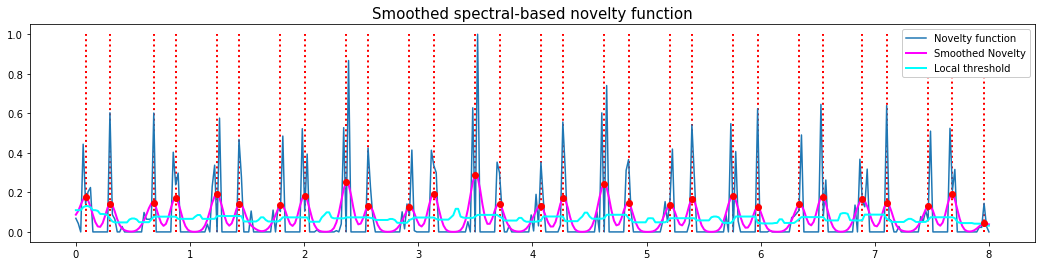

In [24]:
plt.figure(figsize=([18, 4]))
plot_function_peak_positions(nov_norm, Fs_nov, peaks, 
                             title='Smoothed spectral-based novelty function')

time = np.arange(nov_norm.shape[0]) / Fs_nov
peaks_sec = time[peaks]

plt.plot(time, smoothed, color='magenta', linewidth=2);
plt.plot(time, threshold_local, color='cyan', linewidth=2);
plt.plot(peaks_sec, smoothed[peaks], 'ro')
plt.legend(['Novelty function',  'Smoothed Novelty', 'Local threshold'], 
           loc='upper right', framealpha=1);

x_peaks = librosa.clicks(peaks_sec, sr=Fs, click_freq=1000, length=len(x))
ipd.display(ipd.Audio(x + x_peaks, rate=Fs))

#### Picks per minute (ppm) <a id='picks'></a>

Using the **smoothed spectral-based novelty function**, we have defined the time domain signature produced by the fly-shuttle back and forth by selecting the peaks exceeding the local average of our function. We will now focus on determining the picks laid in one minute. 

A **pick** is made when the fly-shuttle inserts one filling yarn during its flight. As we could see in the beginning of this notebook, the picking mechanism of the loom starts with the fly-shuttle weaving the weft by passing through the shed (*picking*) and entering into the shuttle box (*checking*). 

Phases in shuttle movement :

- **Picking** (or acceleration)
- **Free flight**
- **Checking** (or retardation)

Now, one can do some simple arithmetic calculations in order to define the ppm, the cycle per seconds and the loom cycle (equivalent to two picks).

In [25]:
ppm = (len(peaks) / 2) * (60 / x_duration)
cycles = (ppm / 2) / 60
loom_cycle = (peaks[3] - peaks[0]) / Fs_nov

print(f"""Picks per minute (ppm) : {ppm:0.0f} 
Cycle per seconds : {cycles:0.1f} 
Loom cycle (two picks): {loom_cycle:0.2f} second""")

Picks per minute (ppm) : 109 
Cycle per seconds : 0.9 
Loom cycle (two picks): 0.79 second


Finally, we can express the operational speeds of the respective looms by the picks laid in one minute.

- **French *hand loom* from the 19th century** operates approximately at **30 ppm** or  **0.2 cycle per second**.
- **French *power loom* Nanterme & Fils (1925)** operates approximately at **109 ppm** or **0.9 cycle per second**.
- **Japanese *air-jet loom* Tsudakoma (1980)** operates approximately at **214 ppm** or **1.8 cycles per second**.

> *N.B. The hand loom cannot be assessed accurately because the person in charge of the weaving process does not weave with the pace of a 19th century weaver.* 

### Noise measurements <a id='noise'></a>

To conclude this study, we will compare the noise levels and frequency components produced by the 3 respective looms in action in order to consider the evolution of noise exposure in the textile industry.

>*Industrial noise is one of the major noise pollutants that leads to various health hazards. Continuous exposure to noise is reported to have many adverse effects, both physiological and psychological, and it is a very serious problem among people working in a textile industry. A study by **Mokhthar et al .**,**[[3]](#ref)** on the effects of noise observed that the physiology, hearing capability, auditory communication, and sleep of industrial workers were significantly affected by noise levels. Noise levels and their frequencies are observed to be varied in various industries involving multiple operations of machinery. This affects the workers who work very close to the machinery. Repeated exposure to noise levels between 80 and 90 dB (A) involves some degree of risk.*

Let's import the noise measurements made with the class 1 integrating sound level meter.

In [26]:
df = pd.read_excel("measurements/slm-b&k-2245.xlsx")

Then, we can assess the equivalent continuous sound pressure level (LAeq) of the respective looms over a given period of time. To this end, we will define a threshold corresponding to the minimum noise levels produced by the loom in action with the **pandas library** and design a simple **average function** with Python.

In [27]:
airjet_db = df.loc[(df['Mesurage'] == 'M08') & (df['LAeq'] > 84)]
airjet_values = airjet_db['LAeq'].values.tolist()

power_db = df.loc[(df['Mesurage'] == 'M06') & (df['LAeq'] > 88)]
power_values = power_db['LAeq'].values.tolist()

hand_db = df.loc[(df['Mesurage'] == 'M01') & (df['LAeq'] > 67)]
hand_values = hand_db['LAeq'].values.tolist()

In [28]:
def Average(lst):
    return sum(lst) / len(lst)

In [29]:
db_1 = Average(airjet_values)
db_2 = Average(power_values)
db_3 = Average(hand_values)

### Power Spectrums <a id='power'></a>

Finally, we can analyze the power spectrums of the respective looms by importing the audio files recorded with the microphone of the integrated sound level meter.

In [30]:
hand_PS = "measurements/hand-loom.wav"
power_PS = "measurements/power-loom.wav"
airjet_PS = "measurements/airjet-loom.wav"

In [31]:
Fs_PS = 44100 # B&K 2245 audio sampling rate

In [32]:
x_1, Fs_PS = librosa.load(hand_PS, Fs)
x_2, Fs_PS = librosa.load(power_PS, Fs)
x_3, Fs_PS = librosa.load(airjet_PS, sr=Fs)

In [33]:
hand_loom = librosa.amplitude_to_db(np.abs(np.fft.fft(x_1)))
power_loom = librosa.amplitude_to_db(np.abs(np.fft.fft(x_2)))
airjet_loom = librosa.amplitude_to_db(np.abs(np.fft.fft(x_3)))

### Visualizing the data

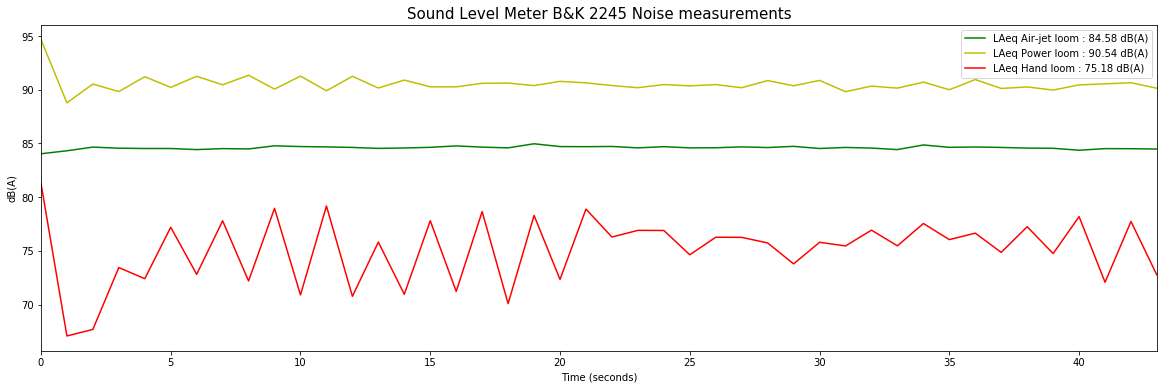

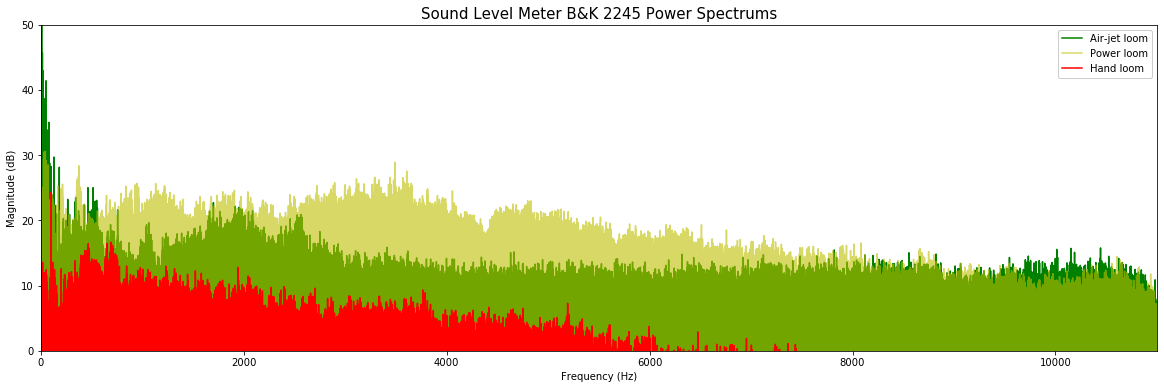

In [34]:
# Noise measurements 
plt.figure(figsize=(20, 6))
plt.plot(airjet_values, color='g', label=f'LAeq Air-jet loom : {db_1:0.2f} dB(A)')
plt.plot(power_values, color='y', label=f'LAeq Power loom : {db_2:0.2f} dB(A)')
plt.plot(hand_values, color='r', label=f'LAeq Hand loom : {db_3:0.2f} dB(A)')
plt.xlim([0, 43])
plt.xlabel('Time (seconds)')
plt.ylabel('dB(A)')
plt.title('Sound Level Meter B&K 2245 Noise measurements', size=15)
plt.legend(loc='upper right')

plt.show()

# Power spectrums
frequency = np.linspace(0, Fs, len(hand_loom))
frequency_bins = int(len(frequency) * 0.5) # Nyquist frequency

plt.figure(figsize=(20, 6))
plt.plot(frequency[:frequency_bins], airjet_loom[:frequency_bins], 
         color='g', label='Air-jet loom', alpha=1)
plt.plot(frequency[:frequency_bins], power_loom[:frequency_bins], 
         color='y', label='Power loom', alpha=0.6)
plt.plot(frequency[:frequency_bins], hand_loom[:frequency_bins], 
         color='r', label='Hand loom', alpha=1)

plt.legend(loc='upper right', framealpha=1)
plt.title('Sound Level Meter B&K 2245 Power Spectrums', size=15)
plt.xlabel('Frequency (Hz)')
plt.ylabel("Magnitude (dB)")
plt.xlim([0, 11000])
plt.ylim([0, 50])

plt.show()

### References <a id='ref'></a>

- **[1]** *[Fundamentals of Music Processing](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C0/C0.html)*, **Meinard Müller**, 2015, Springer Verlag.
- **[2]** *[Analysis of Fly-Shuttle Loom Noise by Multi-Channel Digital Signal Processing Techniques](https://www.researchgate.net/publication/273379896_Analysis_of_Fly-Shuttle_Loom_Noise_by_Multi-Channel_Digital_Signal_Processing_Techniques/citations)*, **Mehmet Caliskan et al.**, September 1981, Conference: ASME Design Engineering Conference. 
- **[3]** *[A Study On The Effects Of Noise On Industrial Workers In Malaysia](https://www.researchgate.net/publication/228501650_A_Study_On_The_Effects_Of_Noise_On_Industrial_Workers_In_Malaysia)*, **Mohzani Mokhtar et al.**, June 2007, Jurnal Teknologi 46(1):17-30 

#### [Back to Top](#top)